In [1]:
!unzip /content/lfw-deepfunneled.zip -d /content/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0005.jpg  
   creating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Pamela_Melroy/
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Pamela_Melroy/Pamela_Melroy_0001.jpg  
   creating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paola_Espinoza/
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paola_Espinoza/Paola_Espinoza_0001.jpg  
   creating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/Paradorn_Srichaphan_0001.jpg  
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/Paradorn_Srichaphan_0002.jpg  
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Paradorn_Srichaphan/Paradorn_Srichaphan_0003.jpg  
  inflating: /content/dlfinal/lfw-deepfunneled/lfw-deepfunneled/Parad

In [2]:


import shutil
from shutil import unpack_archive
from subprocess import check_output
import keras
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output


lfw_allnames = pd.read_csv("/content/dlfinal/lfw_allnames.csv")




print("Summary:")
print("There are " +
      str(lfw_allnames.shape[0]) +
      " unique celebrities in the entire dataset, of whom " +
      str(sum(lfw_allnames.images > 1)) +
      " are represented by multiple images. The entire number of images available is " +
      str(sum(lfw_allnames.images)) +
      ". The most represented celebrity is " +
      str(lfw_allnames.iloc[lfw_allnames['images'].idxmax()][0]) +
      ", with " +
      str(max(lfw_allnames.images)) +
      " unique images in the dataset.")

# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)


Summary:
There are 5749 unique celebrities in the entire dataset, of whom 1680 are represented by multiple images. The entire number of images available is 13233. The most represented celebrity is George_W_Bush, with 530 unique images in the dataset.


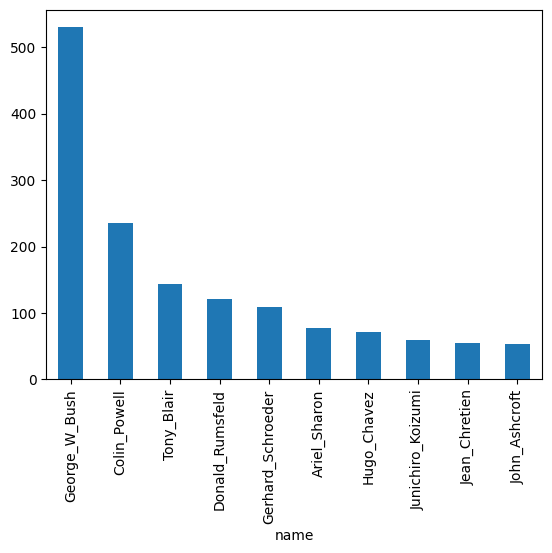

In [3]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")

not_george = image_paths[image_paths.name!="George_W_Bush"].sample(530)
not_george.name = "not_George"
GWB_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"],
                     not_george])
# withhold final test data
bush_train, bush_test = train_test_split(GWB_data, test_size=0.2)
#  It is also useful to reserve a validation set in the training data, for use in the model construction
bush_train, bush_val = train_test_split(bush_train,test_size=0.2)

In [4]:

def directory_mover(data,dir_name):
    co = 0
    for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/',dir_name))

        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/',dir_name,data_type))
        path_from = os.path.join('dlfinal/lfw-deepfunneled/lfw-deepfunneled/',image)
        path_to = os.path.join('/content/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1

    print('Moved {} images to {} folder.'.format(co,dir_name))
# move images:
directory_mover(bush_train,"Bush_train/")
directory_mover(bush_val,"Bush_val/")
directory_mover(bush_test,"Bush_test/")

Moved 678 images to Bush_train/ folder.
Moved 170 images to Bush_val/ folder.
Moved 212 images to Bush_test/ folder.


In [5]:
# define a custom function to move images to a new train/test/val directory
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

Bush_training_set = train_datagen.flow_from_directory('Bush_train',
                                                 target_size = (250, 250),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
Bush_val_set = test_datagen.flow_from_directory('Bush_val',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')
Bush_test_set = test_datagen.flow_from_directory('Bush_test',
                                            target_size = (250, 250),
                                            batch_size = 32,
                                            class_mode = 'binary')


# Determine correct steps per epoch
steps_per_epoch = len(Bush_training_set)
validation_steps = len(Bush_val_set)

Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


Found 678 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 212 images belonging to 2 classes.
Training and evaluating model CNN-S
Epoch 1/50
22/22 [==============================] - 15s 381ms/step - loss: 0.9912 - accuracy: 0.5029 - val_loss: 0.6877 - val_accuracy: 0.5529
Epoch 2/50
22/22 [==============================] - 9s 400ms/step - loss: 0.6907 - accuracy: 0.5900 - val_loss: 0.6759 - val_accuracy: 0.6882
Epoch 3/50
22/22 [==============================] - 9s 402ms/step - loss: 0.6432 - accuracy: 0.6460 - val_loss: 0.5572 - val_accuracy: 0.7059
Epoch 4/50
22/22 [==============================] - 9s 402ms/step - loss: 0.5417 - accuracy: 0.7286 - val_loss: 0.5251 - val_accuracy: 0.7588
Epoch 5/50
22/22 [==============================] - 9s 403ms/step - loss: 0.4952 - accuracy: 0.7611 - val_loss: 0.4970 - val_accuracy: 0.7588
Epoch 6/50
22/22 [==============================] - 9s 400ms/step - loss: 0.4541 - accuracy: 0.7979 - val_loss: 0.4582 - val_accur

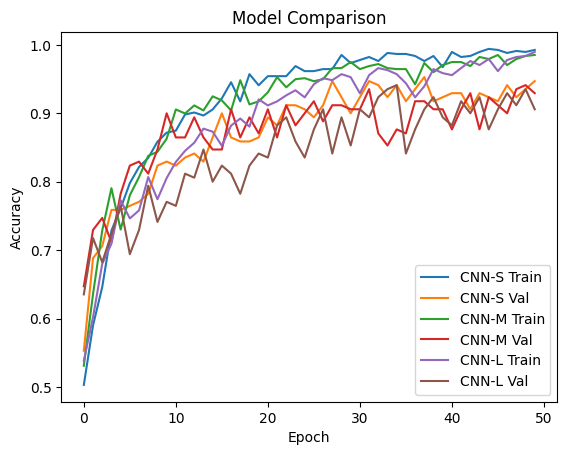

In [6]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.initializers import GlorotUniform

# Define the model builders
def build_model_cnn_s(input_shape):
    model = Sequential([
        Conv2D(12, (5, 5), input_shape=input_shape, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(5000, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model_cnn_m(input_shape):
    model = Sequential([
        Conv2D(24, (4, 4), input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (4, 4), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(16, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(5000, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_model_cnn_l(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), strides=(2, 2), input_shape=input_shape, activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(48, (3, 3), strides=(2, 2), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(5000, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Image Data Generator Setup
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

def train_and_evaluate_model(model_builder, train_set, val_set, test_set):
    model = model_builder((250, 250, 3))
    history = model.fit(
        train_set,
        steps_per_epoch=len(train_set),
        epochs=50,
        validation_data=val_set,
        validation_steps=len(val_set)
    )
    test_loss, test_acc = model.evaluate(test_set)
    return history, test_loss, test_acc

# Load Data
Bush_training_set = train_datagen.flow_from_directory('Bush_train/', target_size=(250, 250), batch_size=32, class_mode='binary')
Bush_val_set = test_datagen.flow_from_directory('Bush_val/', target_size=(250, 250), batch_size=32, class_mode='binary')
Bush_test_set = test_datagen.flow_from_directory('Bush_test/', target_size=(250, 250), batch_size=32, class_mode='binary')

# Train and Evaluate Models
models = [build_model_cnn_s, build_model_cnn_m, build_model_cnn_l]
model_suffixes = ['S', 'M', 'L']
results = {}
for i, model_builder in enumerate(models):
    model_suffix = model_suffixes[i]
    print(f"Training and evaluating model CNN-{model_suffix}")
    history, test_loss, test_acc = train_and_evaluate_model(model_builder, Bush_training_set, Bush_val_set, Bush_test_set)
    results[f"CNN-{model_suffix}"] = (history, test_loss, test_acc)

# Display results
for key, value in results.items():
    print(f"{key} Test Accuracy: {value[2]}")
    plt.plot(value[0].history['accuracy'], label=f"{key} Train")
    plt.plot(value[0].history['val_accuracy'], label=f"{key} Val")
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [7]:
# prompt: Use Bush_test to make prediction with three models, and print all accuracy and loss for each model

# Make predictions with each model
predictions_s = build_model_cnn_s((250, 250, 3)).predict(Bush_test_set, steps=len(Bush_test_set))
predictions_m = build_model_cnn_m((250, 250, 3)).predict(Bush_test_set, steps=len(Bush_test_set))
predictions_l = build_model_cnn_l((250, 250, 3)).predict(Bush_test_set, steps=len(Bush_test_set))

# Calculate accuracy and loss for each model
loss_s, accuracy_s = build_model_cnn_s((250, 250, 3)).evaluate(Bush_test_set, steps=len(Bush_test_set))
loss_m, accuracy_m = build_model_cnn_m((250, 250, 3)).evaluate(Bush_test_set, steps=len(Bush_test_set))
loss_l, accuracy_l = build_model_cnn_l((250, 250, 3)).evaluate(Bush_test_set, steps=len(Bush_test_set))

# Print results
print(f"CNN-S: Loss: {loss_s}, Accuracy: {accuracy_s * 100}")
print(f"CNN-M: Loss: {loss_m}, Accuracy: {accuracy_m * 100}")
print(f"CNN-L: Loss: {loss_l}, Accuracy: {accuracy_l * 100}")


7/7 [==============================] - 1s 47ms/step - loss: 0.6934 - accuracy: 0.5189
CNN-S: Loss: 0.7000306248664856, Accuracy: 43.396225571632385
CNN-M: Loss: 0.6933000087738037, Accuracy: 52.358490228652954
CNN-L: Loss: 0.6934162974357605, Accuracy: 51.88679099082947
